##**3. Word2Vec**
1. 주어진 단어들을 word2vec 모델에 들어갈 수 있는 형태로 만듭니다.
2. CBOW, Skip-gram 모델을 각각 구현합니다.
3. 모델을 실제로 학습해보고 결과를 확인합니다.
4. 산점도를 그려 단어들의 대략적인 위치를 확인해봅니다

### **필요 패키지 import**

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (21.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 48.8 MB/s 


In [3]:
from tqdm import tqdm
from konlpy.tag import Mecab,Twitter,Okt,Kkma
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import torch
import copy
import numpy as np

### **데이터 전처리**



데이터를 확인하고 Word2Vec 형식에 맞게 전처리합니다.  

In [4]:
train_data = [
  "정말 맛있습니다. 추천합니다.",
  "기대했던 것보단 별로였네요.",
  "다 좋은데 가격이 너무 비싸서 다시 가고 싶다는 생각이 안 드네요.",
  "완전 최고입니다! 재방문 의사 있습니다.",
  "음식도 서비스도 다 만족스러웠습니다.",
  "위생 상태가 좀 별로였습니다. 좀 더 개선되기를 바랍니다.",
  "맛도 좋았고 직원분들 서비스도 너무 친절했습니다.",
  "기념일에 방문했는데 음식도 분위기도 서비스도 다 좋았습니다.",
  "전반적으로 음식이 너무 짰습니다. 저는 별로였네요.",
  "위생에 조금 더 신경 썼으면 좋겠습니다. 조금 불쾌했습니다."       
]

test_words = ["음식", "맛", "서비스", "위생", "가격"]

Tokenization과 vocab을 만드는 과정은 이전 실습과 유사합니다.

In [5]:
tokenizer = Okt()

In [10]:
def make_tokenized(data):
  tokenized = []
  for sent in tqdm(data):
    tokens = tokenizer.morphs(sent, stem=True)
    tokenized.append(tokens)

  return tokenized

In [12]:
train_tokenized = make_tokenized(train_data)
train_tokenized

100%|██████████| 10/10 [00:00<00:00, 60.04it/s]


[['정말', '맛있다', '.', '추천', '하다', '.'],
 ['기대하다', '것', '보단', '별로', '이다', '.'],
 ['다',
  '좋다',
  '가격',
  '이',
  '너무',
  '비싸다',
  '다시',
  '가다',
  '싶다',
  '생각',
  '이',
  '안',
  '드네',
  '요',
  '.'],
 ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'],
 ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'],
 ['위생',
  '상태',
  '가',
  '좀',
  '별로',
  '이다',
  '.',
  '좀',
  '더',
  '개선',
  '되다',
  '기르다',
  '바라다',
  '.'],
 ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'],
 ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'],
 ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'],
 ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]

In [13]:
word_count = defaultdict(int)

for tokens in tqdm(train_tokenized):
  for token in tokens:
    word_count[token] += 1

100%|██████████| 10/10 [00:00<00:00, 5088.94it/s]


In [15]:
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print(list(word_count))

[('.', 14), ('도', 7), ('이다', 4), ('좋다', 4), ('별로', 3), ('다', 3), ('이', 3), ('너무', 3), ('음식', 3), ('서비스', 3), ('하다', 2), ('방문', 2), ('위생', 2), ('좀', 2), ('더', 2), ('에', 2), ('조금', 2), ('정말', 1), ('맛있다', 1), ('추천', 1), ('기대하다', 1), ('것', 1), ('보단', 1), ('가격', 1), ('비싸다', 1), ('다시', 1), ('가다', 1), ('싶다', 1), ('생각', 1), ('안', 1), ('드네', 1), ('요', 1), ('완전', 1), ('최고', 1), ('!', 1), ('재', 1), ('의사', 1), ('있다', 1), ('만족스럽다', 1), ('상태', 1), ('가', 1), ('개선', 1), ('되다', 1), ('기르다', 1), ('바라다', 1), ('맛', 1), ('직원', 1), ('분들', 1), ('친절하다', 1), ('기념일', 1), ('분위기', 1), ('전반', 1), ('적', 1), ('으로', 1), ('짜다', 1), ('저', 1), ('는', 1), ('신경', 1), ('써다', 1), ('불쾌하다', 1)]


In [16]:
w2i = {}
for pair in tqdm(word_count):
  if pair[0] not in w2i:
    w2i[pair[0]] = len(w2i)

i2w={v:k for k,v in w2i.items()}

100%|██████████| 60/60 [00:00<00:00, 272652.48it/s]


In [19]:
print(train_tokenized)
print()
print(w2i)
print()
print(i2w)

[['정말', '맛있다', '.', '추천', '하다', '.'], ['기대하다', '것', '보단', '별로', '이다', '.'], ['다', '좋다', '가격', '이', '너무', '비싸다', '다시', '가다', '싶다', '생각', '이', '안', '드네', '요', '.'], ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'], ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'], ['위생', '상태', '가', '좀', '별로', '이다', '.', '좀', '더', '개선', '되다', '기르다', '바라다', '.'], ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'], ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'], ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'], ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]

{'.': 0, '도': 1, '이다': 2, '좋다': 3, '별로': 4, '다': 5, '이': 6, '너무': 7, '음식': 8, '서비스': 9, '하다': 10, '방문': 11, '위생': 12, '좀': 13, '더': 14, '에': 15, '조금': 16, '정말': 17, '맛있다': 18, '추천': 19, '기대하다': 20, '것': 21, '보단': 22, '가격': 23, '비싸다': 24, '다시': 25, '가다': 26, '싶다': 27, '생각': 28, '안': 29, '드네': 30, '요': 31, '완전': 32, '최고': 33, '!': 34, '재': 35, '의사': 36, '있다': 37, '만족스럽다': 38, '상

### 다음은 Word2Vec을 학습시키는 대표적인 방법인 Skipgram과 CBoW를 다룹니다. 

* CboW는 주변단어를 이용해, 주어진 단어를 예측하는 방법입니다.
* Skipgram은 중심 단어를 이용하여 주변 단어를 예측하는 방법입니다.
* 즉 데이터셋을 구성할때, input x 와 target y를 어떻게 설정하는지에 차이가 있습니다.

참고자료 

* https://simonezz.tistory.com/35 

* https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314 



실제 모델에 들어가기 위한 input을 만들기 위해 `Dataset` 클래스를 정의합니다.

In [20]:
class CBOWDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = [] # input word
    self.y = [] # target word

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
          ############################ ANSWER HERE ################################
          # TODO 1: insert tokens for input self.x
          # TODO 2: insert tokens for targets self.y
          self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
          self.y.append(id)
          #########################################################################        


    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수, 2 * window_size)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [21]:
class SkipGramDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = []
    self.y = []

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
            ############################ ANSWER HERE ################################
          # TODO 1: insert tokens for input self.x
          # TODO 2: insert tokens for targets self.y
          self.y += (token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
          self.x += [id] * 2 * window_size
          #########################################################################        


    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

각 모델에 맞는 `Dataset` 객체를 생성합니다.

In [22]:
cbow_set = CBOWDataset(train_tokenized)
skipgram_set = SkipGramDataset(train_tokenized)
print(list(skipgram_set))

100%|██████████| 10/10 [00:00<00:00, 35394.97it/s]

[(tensor(0), tensor(17)), (tensor(0), tensor(18)), (tensor(0), tensor(19)), (tensor(0), tensor(10)), (tensor(19), tensor(18)), (tensor(19), tensor(0)), (tensor(19), tensor(10)), (tensor(19), tensor(0)), (tensor(22), tensor(20)), (tensor(22), tensor(21)), (tensor(22), tensor(4)), (tensor(22), tensor(2)), (tensor(4), tensor(21)), (tensor(4), tensor(22)), (tensor(4), tensor(2)), (tensor(4), tensor(0)), (tensor(23), tensor(5)), (tensor(23), tensor(3)), (tensor(23), tensor(6)), (tensor(23), tensor(7)), (tensor(6), tensor(3)), (tensor(6), tensor(23)), (tensor(6), tensor(7)), (tensor(6), tensor(24)), (tensor(7), tensor(23)), (tensor(7), tensor(6)), (tensor(7), tensor(24)), (tensor(7), tensor(25)), (tensor(24), tensor(6)), (tensor(24), tensor(7)), (tensor(24), tensor(25)), (tensor(24), tensor(26)), (tensor(25), tensor(7)), (tensor(25), tensor(24)), (tensor(25), tensor(26)), (tensor(25), tensor(27)), (tensor(26), tensor(24)), (tensor(26), tensor(25)), (tensor(26), tensor(27)), (tensor(26), tens

### **모델 Class 구현**

차례대로 두 가지 Word2Vec 모델을 구현합니다.  


*   `self.embedding`: `vocab_size` 크기의 one-hot vector를 특정 크기의 `dim` 차원으로 embedding 시키는 layer.
*   `self.linear`: 변환된 embedding vector를 다시 원래 `vocab_size`로 바꾸는 layer.


In [23]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, dim):
    super(CBOW, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x):  # x: (B, 2W)
    embeddings = self.embedding(x)  # (B, 2W, d_w)
    embeddings = torch.sum(embeddings, dim=1)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

In [24]:
class SkipGram(nn.Module):
  def __init__(self, vocab_size, dim):
    super(SkipGram, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x): # x: (B)
    embeddings = self.embedding(x)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

두 가지 모델을 생성합니다.

In [25]:
cbow = CBOW(vocab_size=len(w2i), dim=256)
skipgram = SkipGram(vocab_size=len(w2i), dim=256)

### **모델 학습**

다음과 같이 hyperparamter를 세팅하고 `DataLoader` 객체를 만듭니다.

In [27]:
batch_size=4
learning_rate = 5e-4
num_epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

첫번째로 CBOW 모델 학습입니다.

In [30]:
cbow.train()
cbow = cbow.to(device)
optim = torch.optim.SGD(cbow.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
  print("#" * 50)
  print(f"Epoch: {e}")
  for batch in tqdm(cbow_loader):
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = cbow(x)  # (B, V)
 
    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

    print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


100%|██████████| 16/16 [00:00<00:00, 449.37it/s]


Train loss: 4.297618389129639
Train loss: 4.217676162719727
Train loss: 3.585211992263794
Train loss: 3.36354923248291
Train loss: 2.841198682785034
Train loss: 2.93984317779541
Train loss: 3.7310338020324707
Train loss: 3.9674315452575684
Train loss: 3.597597599029541
Train loss: 3.700366497039795
Train loss: 4.280869960784912
Train loss: 3.4715685844421387
Train loss: 2.9101059436798096
Train loss: 3.607541799545288
Train loss: 3.99641752243042
Train loss: 3.7235562801361084
##################################################
Epoch: 2


100%|██████████| 16/16 [00:00<00:00, 368.15it/s]


Train loss: 4.122655868530273
Train loss: 4.082393646240234
Train loss: 3.4514763355255127
Train loss: 3.271561622619629
Train loss: 2.7428338527679443
Train loss: 2.741809844970703
Train loss: 3.5823068618774414
Train loss: 3.8333847522735596
Train loss: 3.496826410293579
Train loss: 3.550662040710449
Train loss: 4.127963066101074
Train loss: 3.170661449432373
Train loss: 2.8073055744171143
Train loss: 3.5133094787597656
Train loss: 3.8413846492767334
Train loss: 3.611443519592285
##################################################
Epoch: 3


100%|██████████| 16/16 [00:00<00:00, 443.36it/s]


Train loss: 3.9503185749053955
Train loss: 3.9498980045318604
Train loss: 3.3216278553009033
Train loss: 3.181483745574951
Train loss: 2.6468124389648438
Train loss: 2.5568904876708984
Train loss: 3.436779737472534
Train loss: 3.702324390411377
Train loss: 3.3992133140563965
Train loss: 3.407315969467163
Train loss: 3.9808244705200195
Train loss: 2.8870298862457275
Train loss: 2.707211494445801
Train loss: 3.421675443649292
Train loss: 3.689615488052368
Train loss: 3.502812147140503
##################################################
Epoch: 4


100%|██████████| 16/16 [00:00<00:00, 426.17it/s]


Train loss: 3.7807657718658447
Train loss: 3.8201088905334473
Train loss: 3.1955270767211914
Train loss: 3.09324049949646
Train loss: 2.553170919418335
Train loss: 2.385996103286743
Train loss: 3.2946722507476807
Train loss: 3.574321746826172
Train loss: 3.304776430130005
Train loss: 3.2706336975097656
Train loss: 3.8399503231048584
Train loss: 2.6228291988372803
Train loss: 2.609853506088257
Train loss: 3.3325419425964355
Train loss: 3.5412871837615967
Train loss: 3.3975489139556885
##################################################
Epoch: 5


  0%|          | 0/16 [00:00<?, ?it/s]

Train loss: 3.6142020225524902


100%|██████████| 16/16 [00:00<00:00, 427.05it/s]

Train loss: 3.6929829120635986
Train loss: 3.0730535984039307
Train loss: 3.0067596435546875
Train loss: 2.4619407653808594
Train loss: 2.2296345233917236
Train loss: 3.1562235355377197
Train loss: 3.4494504928588867
Train loss: 3.2135229110717773
Train loss: 3.14076566696167
Train loss: 3.7057948112487793
Train loss: 2.38008975982666
Train loss: 2.5152535438537598
Train loss: 3.245830535888672
Train loss: 3.396615982055664
Train loss: 3.2955527305603027
Finished.


다음으로 Skip-gram 모델 학습입니다.

In [29]:
skipgram.train()
skipgram = skipgram.to(device)
optim = torch.optim.SGD(skipgram.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
  print("#" * 50)
  print(f"Epoch: {e}")
  for batch in tqdm(skipgram_loader):
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = skipgram(x)  # (B, V)

    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

  print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


100%|██████████| 64/64 [00:00<00:00, 918.23it/s]


Train loss: 4.898638725280762
##################################################
Epoch: 2


100%|██████████| 64/64 [00:00<00:00, 823.34it/s]


Train loss: 4.85079288482666
##################################################
Epoch: 3


100%|██████████| 64/64 [00:00<00:00, 811.91it/s]


Train loss: 4.803236484527588
##################################################
Epoch: 4


100%|██████████| 64/64 [00:00<00:00, 856.26it/s]


Train loss: 4.755971908569336
##################################################
Epoch: 5


100%|██████████| 64/64 [00:00<00:00, 855.39it/s]

Train loss: 4.70900297164917
Finished.


### **테스트**

학습된 각 모델을 이용하여 test 단어들의 word embedding을 확인합니다.

In [31]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = cbow.embedding(input_id)

  print(f"Word: {word}")
  print(f"w2i[word]: {w2i[word]}")
  print(emb.squeeze(0))

Word: 음식
w2i[word]: 8
tensor([ 5.2992e-01,  2.1189e+00, -1.7974e+00, -3.5114e-01,  1.9243e+00,
        -1.3335e+00,  4.9476e-02, -8.5000e-01, -1.5052e+00, -5.3449e-01,
        -1.1746e+00, -7.4601e-01,  1.2954e+00,  1.6602e+00,  1.5289e-01,
         2.7537e-01, -1.2049e+00,  1.0933e+00,  1.1584e-01, -2.9945e-01,
        -6.8950e-01, -1.9850e-01,  3.4524e-01,  1.4285e+00, -1.7953e-01,
        -1.0285e+00, -5.3260e-01, -6.9546e-01, -3.4045e-01, -1.4651e+00,
        -9.8982e-01, -9.9681e-01,  2.9218e-01,  5.6220e-01,  4.7143e-01,
        -1.6193e+00,  3.8939e-01,  1.7083e+00,  9.4096e-02, -1.5825e-01,
        -3.1324e-01, -6.9984e-01,  5.2397e-01, -8.8000e-01,  1.6525e+00,
        -1.2585e+00,  2.0743e-02,  1.1960e-02, -1.1229e+00, -1.2404e+00,
        -9.1786e-01, -1.1853e+00,  2.4117e-01,  5.3276e-01, -8.3940e-01,
         2.1868e+00, -1.4669e+00, -4.0026e-01, -1.0568e+00, -8.1377e-01,
         1.5899e+00,  9.4744e-01, -1.6827e+00,  1.1312e+00,  1.5501e+00,
         6.6222e-01,  3.4621e

In [32]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = skipgram.embedding(input_id)

  print(f"Word: {word}")
  print(max(emb.squeeze(0)))

Word: 음식
tensor(3.1520, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 맛
tensor(3.5062, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 서비스
tensor(2.3904, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 위생
tensor(3.4639, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 가격
tensor(2.8429, device='cuda:0', grad_fn=<UnbindBackward0>)


In [33]:
test_words

['음식', '맛', '서비스', '위생', '가격']

In [34]:
i2w[25]

'다시'

In [35]:
def most_similar(word,top_k=5):
  input_id = torch.LongTensor([w2i[word]]).to(device)
  input_emb = skipgram.embedding(input_id)
  score=torch.matmul(input_emb,skipgram.embedding.weight.transpose(1,0)).view(-1)

  _,top_k_ids=torch.topk(score,top_k)

  return [i2w[word_id.item()] for word_id in top_k_ids][1:]

In [36]:
most_similar("가격")

['개선', '에', '너무', '싶다']

## Word2Vec 시각화

In [46]:
from sklearn.decomposition import PCA

In [61]:
import matplotlib.pyplot as plt
#matplotlib 패키지 한글 깨짐 처리 시작
# plt.rc('font', family='NanumMyeongjo') 
plt.rc('font', family='AppleGothic') #맥

In [62]:
pca=PCA(n_components=2)

In [63]:
pc_weight=pca.fit_transform(skipgram.embedding.weight.data.cpu().numpy())

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text

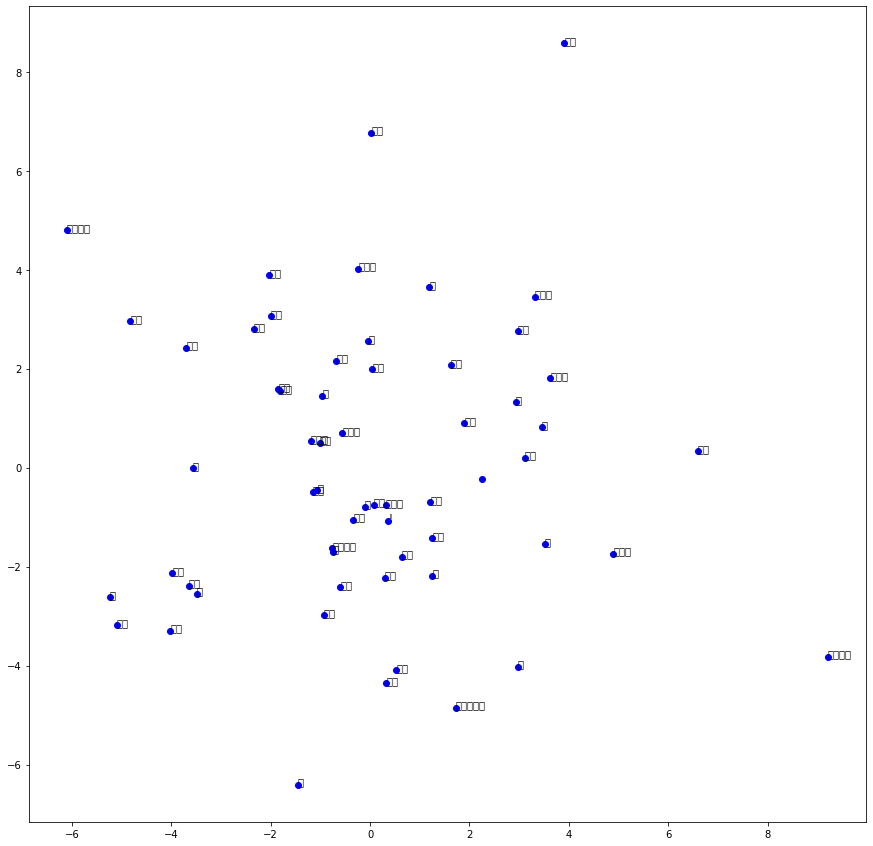

In [64]:
plt.figure(figsize=(15,15))

for word_id,(x_coordinate,y_coordinate) in enumerate(pc_weight):
  plt.scatter(x_coordinate,y_coordinate,color="blue")
  plt.annotate(i2w[word_id], (x_coordinate, y_coordinate))